# Trying out LDA with hierarchical dirichlet process (HDP) prior

Here, the number of topics is learned from the data.
Refs:
* http://people.eecs.berkeley.edu/~jordan/papers/hdp.pdf
* http://www.arbylon.net/publications/ilda.pdf

Using the inference code developed by someone else for now! Install from anaconda terminal

    conda install -c datamicroscopes -c distributions microscopes-lda
    conda install -c memex -c distributions pyldavis

### Import stuff

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import itertools
import pyLDAvis
import pandas as pd
import re
import simplejson
from random import shuffle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk')

In [3]:
from microscopes.common.rng import rng
from microscopes.lda.definition import model_definition
from microscopes.lda.model import initialize
from microscopes.lda import model, runner

### Prepare documents

In [4]:
def parse_bag_of_words_file(docword, vocab):
    with open(vocab, "r") as f:
        kos_vocab = [word.strip() for word in f.readlines()]
        id_to_word = {i: word for i, word in enumerate(kos_vocab)}

    with open(docword, "r") as f:
        raw = [map(int, _.strip().split()) for _ in f.readlines()][3:]

    docs = []
    for _, grp in itertools.groupby(raw, lambda x: x[0]):
        doc = []
        for _, word_id, word_cnt in grp:
            doc += word_cnt * [id_to_word[word_id-1]]
        docs.append(doc)
    return docs, id_to_word

docs, id_to_word = parse_bag_of_words_file("docword.kos.txt", "vocab.kos.txt")
vocab_size = len(set(word for doc in docs for word in doc))

In [5]:
print 'total docs = %d' % len(docs)
print 'first doc = %s' % docs[0]

total docs = 3430
first doc = ['action', 'action', 'added', 'administration', 'alliances', 'antiwar', 'approve', 'assault', 'attack', 'attitude', 'attitude', 'aug', 'battle', 'believes', 'broad', 'bush', 'bush', 'career', 'chairman', 'click', 'coalition', 'committee', 'committee', 'compared', 'compared', 'conclude', 'conclusion', 'conclusions', 'congressional', 'congressional', 'congressman', 'congressman', 'considered', 'constituents', 'constituents', 'countrys', 'damaging', 'damn', 'departure', 'destruction', 'district', 'district', 'doug', 'doug', 'dramatic', 'electorate', 'engaged', 'enlarge', 'fact', 'final', 'general', 'general', 'gooper', 'greater', 'hold', 'house', 'house', 'households', 'households', 'inadequate', 'incidentally', 'independents', 'intelligence', 'intelligence', 'intelligence', 'international', 'international', 'iraq', 'iraq', 'ive', 'john', 'justified', 'kerry', 'kerry', 'kerry', 'knowing', 'launch', 'lead', 'letter', 'lower', 'maintained', 'mass', 'member', 'm

In [6]:
for n in range(10):
    print '%d : %s' % (n, id_to_word[n])

0 : aarp
1 : abandon
2 : abandoned
3 : abandoning
4 : abb
5 : abc
6 : abcs
7 : abdullah
8 : ability
9 : aboard


### Initialise LDA

In [10]:
defn = model_definition(len(docs), vocab_size)
prng = rng()
lda = initialize(defn, docs, prng,
                        vocab_hp=1,
                        dish_hps={"alpha": 1, "gamma": 1000})
r = runner.runner(defn, docs, lda)

print "number of docs:", defn.n, "vocabulary size:", defn.v

number of docs: 3430 vocabulary size: 6906


### Run LDA

Will take a while to complete ...

In [ ]:
%%time
step_size = 50
steps = 500 / step_size

print "randomly initialized model:", "perplexity:", lda.perplexity(), "num topics:", lda.ntopics()
for s in range(steps):
    r.run(prng, step_size)
    print "iteration:", (s + 1) * step_size, "perplexity:", lda.perplexity(), "num topics:", lda.ntopics()

randomly initialized model: perplexity: 

### Show LDAvis

In [9]:
prepared = pyLDAvis.prepare(**lda.pyldavis_data())
pyLDAvis.display(prepared)

/Users/joewandy/anaconda/lib/python2.7/site-packages/pyLDAvis/_prepare.py:283: FutureWarning: order is deprecated, use sort_values(...)
  topic_proportion = (topic_freq / topic_freq.sum()).order(ascending=False)
/Users/joewandy/anaconda/lib/python2.7/site-packages/pyLDAvis/_prepare.py:154: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  sort('saliency', ascending=False). \
/Users/joewandy/anaconda/lib/python2.7/site-packages/pyLDAvis/_prepare.py:203: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  return token_table.sort(['Term', 'Topic'])
/Users/joewandy/anaconda/lib/python2.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:109: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be us

### Print top 10 most relevant words in each topic

In [10]:
relevance = lda.term_relevance_by_topic()
for topics in relevance:
    words = [word for word, _ in topics[:10]]
    print ' '.join(words)

november account electoral governor sunzoo contact dkosopedia faq login password
investigation commission documents court administration committee marriage records delay ethics
dean edwards clark gephardt iowa primary lieberman deans democratic kucinich
bush president media kerry cheney john campaign time speech people
iraq war iraqi military troops soldiers saddam baghdad forces american
senate elections race district seat republican house gop democrats carson
party million ballot dnc nader campaign money signatures democratic groups
tax jobs billion health economic budget oil cuts deficit energy
bush kerry percent poll voters polling polls general results florida
rights catholic science human space reagan cell abortion religious scientists
inactive shares reserves investors reservists corp nick deck held calendar
disclaimer zahn predebate auxiliary merit googlebomb graph chit pst lament
zimbabwe indymedia williams freeper orleans ditka anchor trade owners farmers


### Predict topic distribution

In [19]:
# generate some documents from topic 7
doc7 = [word for word, _ in relevance[6][:100]]
shuffle(doc7)
doc_text = [word for word in doc7]
print 'generated document from topic 7'
print ' '.join(doc_text)
print

# generate some documents from topic 1 and 7
doc17 = [word for word, _ in relevance[0][:100]] + [word for word, _ in relevance[6][:100]]
shuffle(doc17)
doc_text = [word for word in doc17]
print 'generated document from topic 1 and 7'
print ' '.join(doc_text)

generated document from topic 7
television volunteers party effort elected expenditures moveonorg oregon forms database leading mail spending straw money ralph ballots organizations establishment dnc general progressive register state convention absentee mccainfeingold grassroots advertising meetup consultants nevada boycott ndn efforts ballot martinez votes spend candidates organization gop dlc simon funds naders sproul mcauliffe parties registration organizing fec donations committee candidate nomination act campaign nominee voters foe dreier petition fund groups internet republican soft national decentralized campaigns green democrats voter nader ads machines fundraising financial pacs raising boxer participation fraud county rosenberg rnc petitions democratic signatures stern partys outreach presidential million republicans political financing election raised

generated document from topic 1 and 7
candidates efforts dem groups trouble password barbero meetup advertising nominee pet

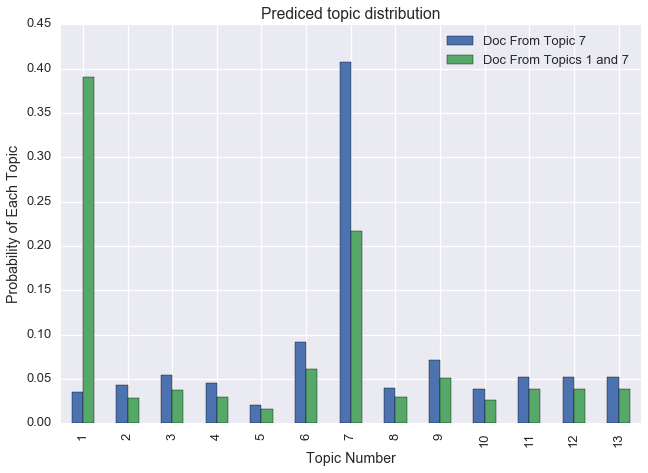

In [21]:
pred = pd.DataFrame()
pred['Doc From Topic 7'] = pd.Series(lda.predict(doc7, rng())[0])
pred['Doc From Topics 1 and 7']= pd.Series(lda.predict(doc17, r)[0])
pred.plot(kind='bar')
plt.title('Prediced topic distribution')
plt.xticks(pred.index, ['%d' % (d+1) for d in xrange(len(pred.index))])
plt.xlabel('Topic Number')
plt.ylabel('Probability of Each Topic')

### Get topic distribution of document

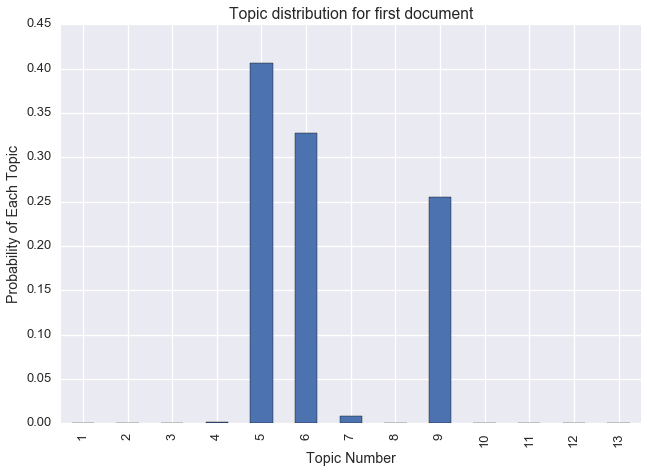

In [22]:
pd.Series(lda.topic_distribution_by_document()[0]).plot(kind='bar').set_title('Topic distribution for first document')
plt.xticks(pred.index, ['%d' % (d+1) for d in xrange(len(pred.index))])
plt.xlabel('Topic Number')
plt.ylabel('Probability of Each Topic')

### Get word distribution of topic

/Users/joewandy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  if __name__ == '__main__':


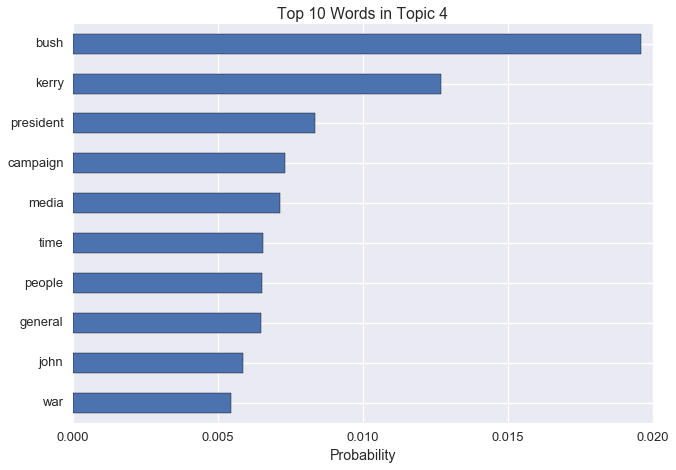

In [23]:
pd.Series(lda.word_distribution_by_topic()[3]).sort(inplace=False).tail(10).plot(kind='barh')
plt.title('Top 10 Words in Topic 4')
plt.xlabel('Probability')